In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_probability as tfp
import yfinance as yf

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from ConcreteDropout import BNN

%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors

plt.rcParams["figure.figsize"] = (12,4)

This is a simple example of application of Probabilistic and Bayesian Neural Networks to estimate aleatoric and epistemic uncertainty in regression problems. We will see that Probabilistic NNs can recover only punctual estimates for mean and variance of data, accessing only the statistical (aleatoric) uncertainty in data, while BNNs can recover entire distributions of parameters for mean and variance of data, enabling to estimate the model (epistemic) uncertainty as well. We use financial returns because of the heterosckedaticity property, which makes the problem interesting. We divide our data into training and test set to see how the different models behave on unseen data, without any aim of achieving high accuracy out-of-sample (it would be impossible given the naive input used). 

## Data

In [2]:
def plot_distribution(preds, means, title, legend):
    ax = plt.subplot()
    ax.scatter(returns.index,y,color="steelblue",marker='.')
    for i in range(preds.shape[0]):
        ax.scatter(returns.index,preds[i],color="orange",marker='.', alpha=0.01)
    ax.plot(returns.index, means, color='red')
    ax.axvline(returns.index[ind], color='black')
    ax.set_title(title)
    ax.legend(legend, loc=3);

[*********************100%***********************]  1 of 1 completed


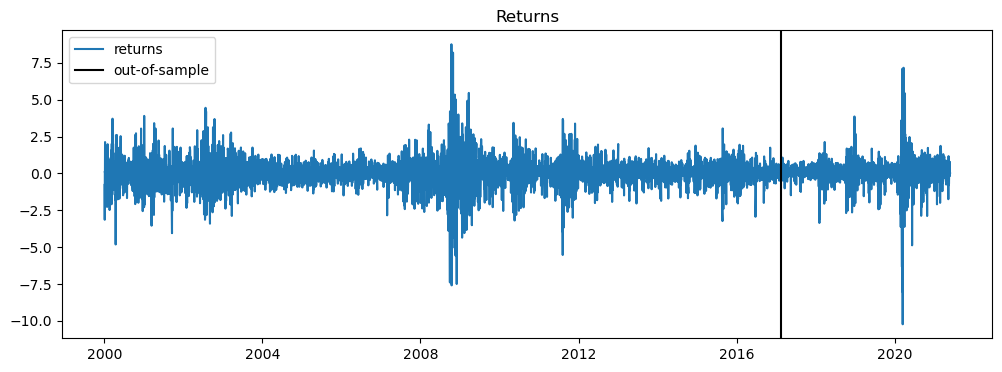

In [3]:
data = yf.download("^GSPC", start="2000-01-01")
returns = np.log(data[['Close']]).diff().dropna()
lenght = len(returns)
x = np.linspace(0, lenght-1, lenght, dtype = 'float32')
x = (x - x.mean())/x.std()
y = np.asarray(returns, dtype='float32')
y = (y - y.mean())/y.std()

ind = int(x.shape[0]*0.8)

_, ax = plt.subplots(1, 1, figsize=(12,4))
ax.plot(returns.index, y, label='returns')
ax.axvline(returns.index[ind], color='black', label='out-of-sample')
ax.set_title(label='Returns')
ax.legend();

In [4]:
x_train, y_train = x[:ind], y[:ind]
x_valid, y_valid = x[ind:], y[ind:]

print('train shape', x_train.shape, y_train.shape)
print('test shape', x_valid.shape, y_valid.shape)

train shape (4308,) (4308, 1)
test shape (1078,) (1078, 1)


## Probabilistic NN with Conditional Gaussian Distribution

$$ 
r_t \sim \mathcal{N}(\mu_t, \sigma^2_t)
$$

In [5]:
def NLL(y, distr): 
    return -distr.log_prob(y) 

def normal(params): 
    return tfd.Normal(loc=params[:,:1], scale=1e-5 + tf.math.softplus(0.05 * params[:,1:]))

tf.keras.backend.clear_session()

inputs = tf.keras.layers.Input(shape=(1,))
hidden = tf.keras.layers.Dense(100,activation="relu")(inputs)
hidden = tf.keras.layers.Dense(500,activation="relu")(hidden)
hidden = tf.keras.layers.Dense(500,activation="relu")(hidden)
hidden = tf.keras.layers.Dense(500,activation="relu")(hidden)
hidden = tf.keras.layers.Dense(100,activation="relu")(hidden)
params = tf.keras.layers.Dense(2)(hidden)
dist = tfp.layers.DistributionLambda(normal)(params)

nn_cgd = Model(inputs=inputs, outputs=dist)
nn_cgd.compile(Adam(0.0001), loss=NLL)

nn_cgd.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 500)               50500     
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 202   

In [6]:
history = nn_cgd.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)

In [7]:
runs = 100
preds_cgd = nn_cgd(x).sample(runs)
means_cgd = nn_cgd(x).mean()
sigmas_cgd = nn_cgd(x).stddev()

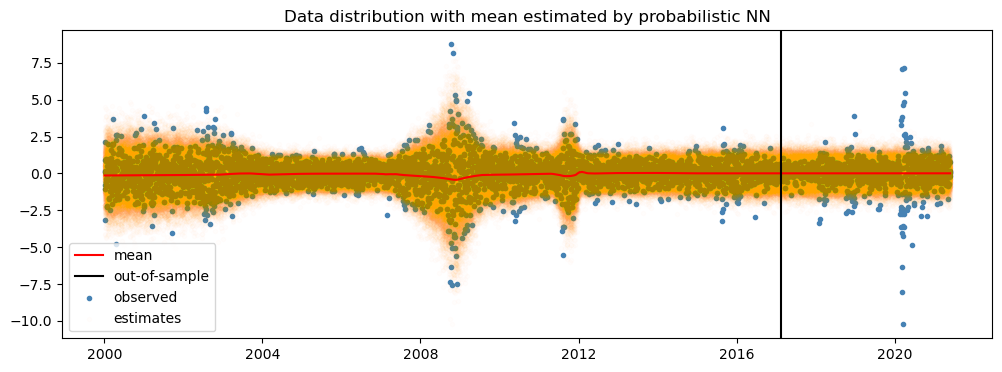

In [8]:
title = 'Data distribution with mean estimated by probabilistic NN'
legend = ['mean', 'out-of-sample', 'observed', 'estimates']
plot_distribution(preds_cgd, means_cgd, title, legend)

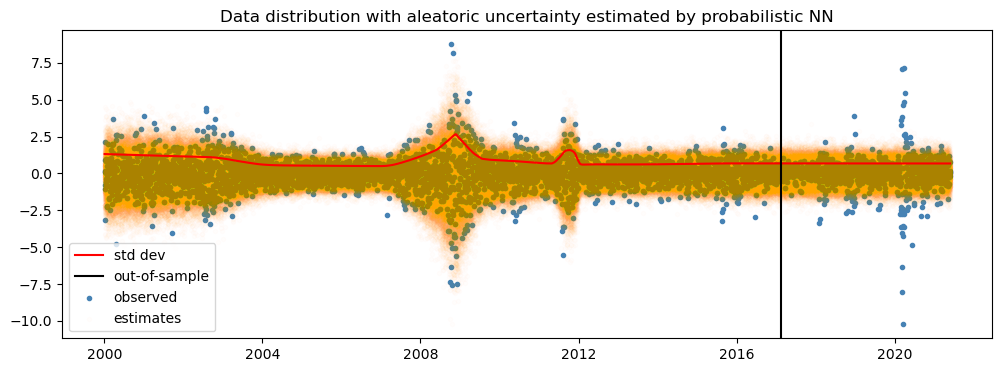

In [9]:
title = 'Data distribution with aleatoric uncertainty estimated by probabilistic NN'
legend = ['std dev', 'out-of-sample', 'observed', 'estimates']
plot_distribution(preds_cgd, sigmas_cgd, title, legend)

## Mixture Density Networks

$$
r_t \sim \sum_{k=1}^K\pi_k(t)\mathcal{N}(\mu_k(t),\sigma^2_k(t))
$$

In [10]:
tf.keras.backend.clear_session()

event_shape = [1]
num_components = 2
params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)


inputs = tf.keras.layers.Input(shape=(1,))
hidden = tf.keras.layers.Dense(100,activation="relu")(inputs)
hidden = tf.keras.layers.Dense(500,activation="relu")(hidden)
hidden = tf.keras.layers.Dense(500,activation="relu")(hidden)
hidden = tf.keras.layers.Dense(500,activation="relu")(hidden)
hidden = tf.keras.layers.Dense(100,activation="relu")(hidden)
params = tf.keras.layers.Dense(params_size)(hidden)
dist = tfp.layers.MixtureNormal(num_components, event_shape)(params)

nn_mdn = Model(inputs=inputs, outputs=dist)
nn_mdn.compile(Adam(0.0001), loss=NLL)

nn_mdn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 500)               50500     
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 606   

In [11]:
history_mdn = nn_mdn.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0)

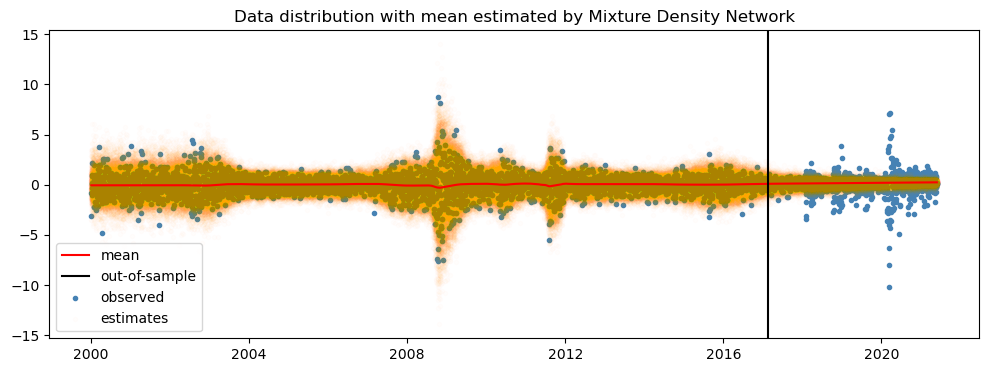

In [12]:
preds_mdn = nn_mdn(x).sample(runs)
means_mdn = nn_mdn(x).mean()
sigmas_mdn = nn_mdn(x).stddev()

title = 'Data distribution with mean estimated by Mixture Density Network'
legend = ['mean', 'out-of-sample', 'observed', 'estimates']
plot_distribution(preds_mdn, means_mdn, title, legend)

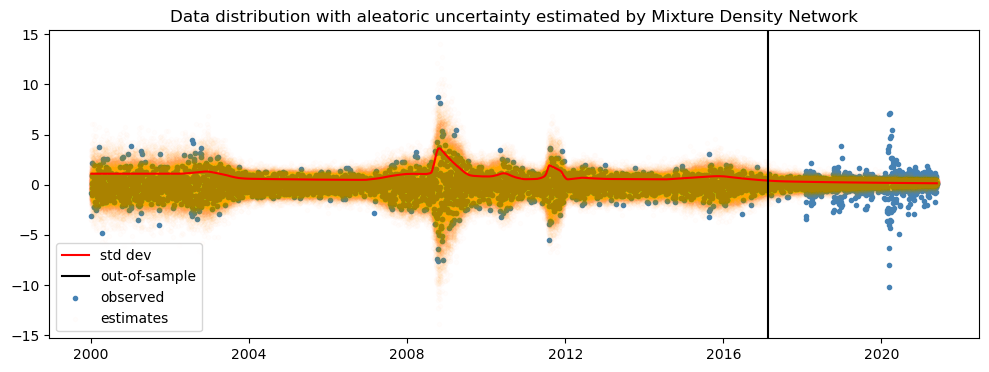

In [13]:
title = 'Data distribution with aleatoric uncertainty estimated by Mixture Density Network'
legend = ['std dev', 'out-of-sample', 'observed', 'estimates']
plot_distribution(preds_mdn, sigmas_mdn, title, legend)

Both probabilistic NNs are prone to overfit data and extend the last recognized pattern to the unseen data, without taking into account the increasing uncertainty.

## Bayesian NN with Variational Inference

In [14]:
tf.keras.backend.clear_session()

kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x_train.shape[0] * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x_train.shape[0] * 1.0)


inputs = tf.keras.layers.Input(shape=(1,))


hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(inputs)
hidden = tfp.layers.DenseFlipout(100,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
hidden = tfp.layers.DenseFlipout(100,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
hidden = tfp.layers.DenseFlipout(100,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
params = tfp.layers.DenseFlipout(2,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(hidden)
dist = tfp.layers.DistributionLambda(normal)(params)  


bnn_vi = Model(inputs=inputs, outputs=dist)
bnn_vi.compile(Adam(learning_rate=0.0005), loss=NLL) 

bnn_vi.summary()

C:\Users\Garcieri\Anaconda3\envs\tfp\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 20)                80        
_________________________________________________________________
dense_flipout_1 (DenseFlipou (None, 100)               4200      
_________________________________________________________________
dense_flipout_2 (DenseFlipou (None, 100)               20200     
_________________________________________________________________
dense_flipout_3 (DenseFlipou (None, 100)               20200     
_________________________________________________________________
dense_flipout_4 (DenseFlipou (None, 20)                4040      
_________________________________________________________________
dense_flipout_5 (DenseFlipou (None, 2)                 84    

In [15]:
history_vi = bnn_vi.fit(x_train, y_train, epochs=1000, batch_size=32, verbose=0)

In [16]:
preds_vi = bnn_vi(x).sample(runs)
means_dist_vi = np.asarray([bnn_vi(x).mean() for _ in range(runs)])
sigmas_dist_vi = np.asarray([bnn_vi(x).stddev() for _ in range(runs)])

epistemic_uncertainty_vi = np.var(means_dist_vi, 0)
avg_means_vi = np.mean(means_dist_vi, 0)
avg_sigmas_vi = np.sqrt(np.mean(sigmas_dist_vi**2, 0))

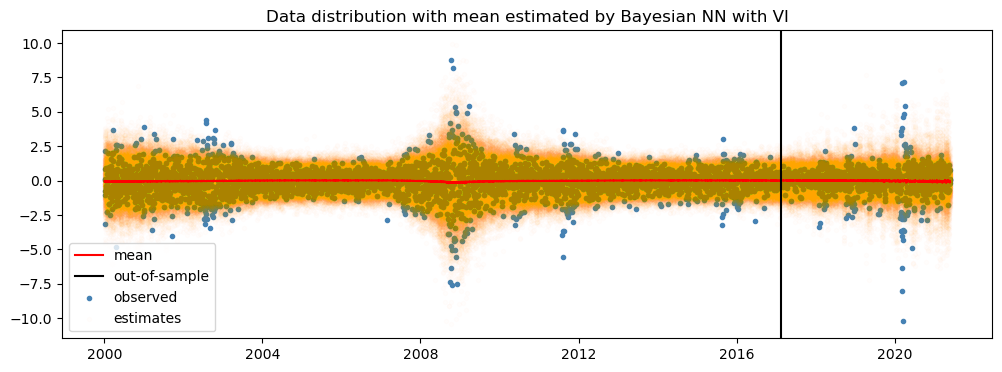

In [18]:
title = 'Data distribution with mean estimated by Bayesian NN with VI'
legend = ['mean', 'out-of-sample', 'observed', 'estimates']
plot_distribution(preds_vi, avg_means_vi, title, legend)

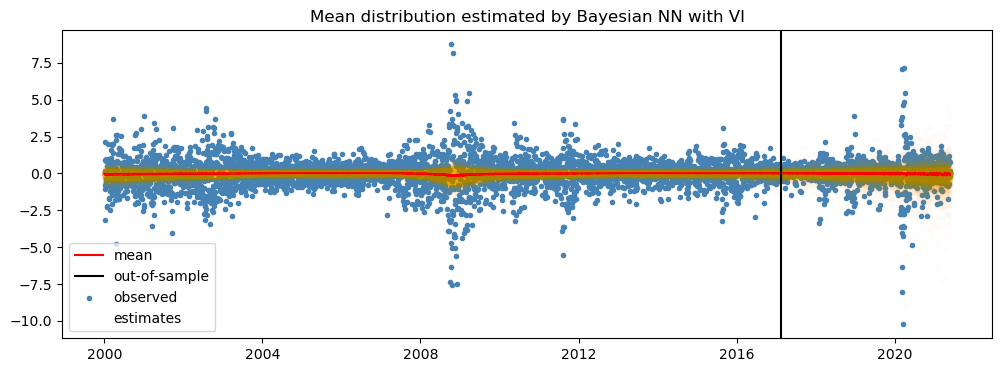

In [19]:
title = 'Mean distribution estimated by Bayesian NN with VI'
legend = ['mean', 'out-of-sample', 'observed', 'estimates']
plot_distribution(means_dist_vi, avg_means_vi, title, legend)

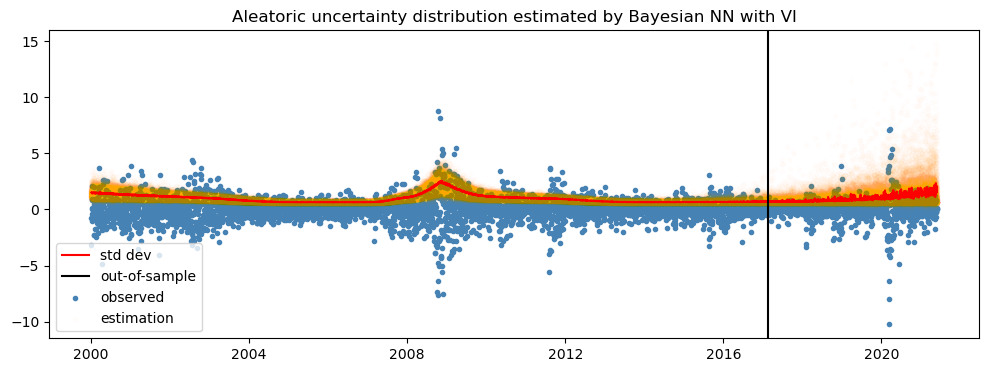

In [20]:
title = 'Aleatoric uncertainty distribution estimated by Bayesian NN with VI'
legend = ['std dev', 'out-of-sample', 'observed', 'estimation']
plot_distribution(sigmas_dist_vi, avg_sigmas_vi, title, legend)

The distributions of data, mean and variance become wider as we move away from the last seen data, taking into account the uncertainty of the model.

## Bayesian NN with Concrete Dropout

In [21]:
tf.keras.backend.clear_session()

bnn_dropout = BNN(x, y, nb_units = 1024)

bnn_dropout.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
concrete_dropout (ConcreteDropo (None, 1024)         2049        input_1[0][0]                    
__________________________________________________________________________________________________
concrete_dropout_1 (ConcreteDro (None, 1024)         1049601     concrete_dropout[0][0]           
__________________________________________________________________________________________________
concrete_dropout_2 (ConcreteDro (None, 1024)         1049601     concrete_dropout_1[0][0]         
______________________________________________________________________________________________

In [22]:
history = bnn_dropout.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0)

In [23]:
means_dist_dropout, logvars_dropout = bnn_dropout.predict(x, T=100)

avg_means_dropout = np.mean(means_dist_dropout, 0)
epistemic_uncertainty_dropout = np.var(means_dist_dropout, 0)
aleatoric_uncertainty_dropout = np.exp(logvars_dropout)
sigmas_dist_dropout = aleatoric_uncertainty_dropout**0.5
avg_sigmas_dropout = np.mean(aleatoric_uncertainty_dropout, 0)**0.5

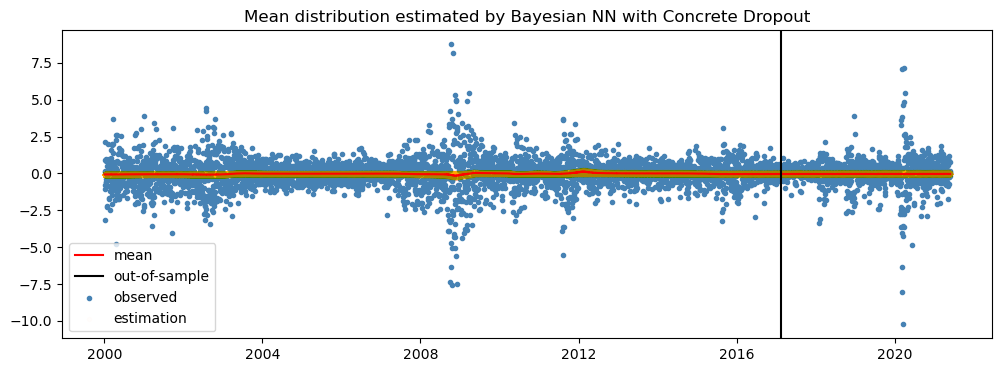

In [24]:
title = 'Mean distribution estimated by Bayesian NN with Concrete Dropout'
legend = ['mean', 'out-of-sample', 'observed', 'estimation']
plot_distribution(means_dist_dropout, avg_means_dropout, title, legend)

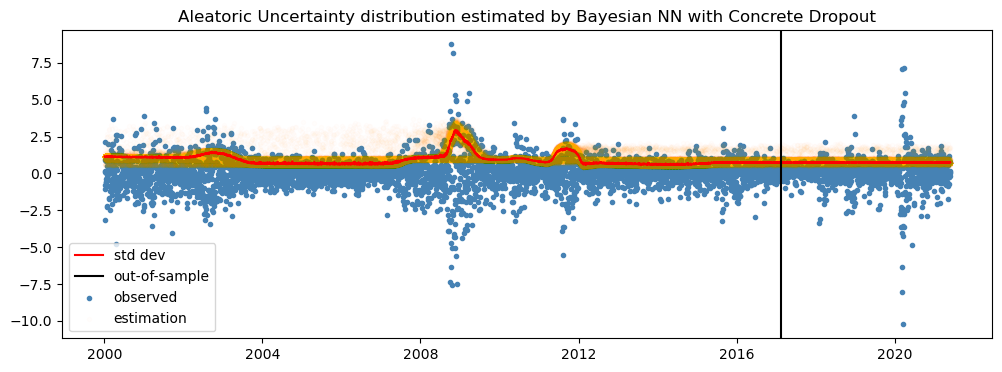

In [25]:
title = 'Aleatoric Uncertainty distribution estimated by Bayesian NN with Concrete Dropout'
legend = ['std dev', 'out-of-sample', 'observed', 'estimation']
plot_distribution(sigmas_dist_dropout, avg_sigmas_dropout, title, legend)

BNN with Concrete Dropout is more conservative but still exhibits similar behavior compared to BNN with Variational Inference.